# Observing reconstruction errors of DBM as a Stacked Auto-Encoder.

This notebook demonstrates DBM as a stacked Auto-Encoder can learn so as to minimize the reconstruction error.

In [20]:
import numpy as np
target_arr = np.random.normal(loc=0.0, scale=1.0, size=(1000, 1000))
target_arr = (target_arr - target_arr.mean()) / target_arr.std()
target_arr

array([[ -2.43630286e-01,   1.80279731e-01,   1.33448719e-01, ...,
          1.89332830e+00,  -1.89897239e+00,  -4.38598893e-01],
       [ -2.69928322e-01,   1.79618173e-01,  -1.12584169e+00, ...,
         -2.35285277e-01,  -8.87395693e-01,  -1.54995583e+00],
       [  3.64282865e-01,  -1.12719176e+00,  -3.22530494e-01, ...,
          7.56738237e-01,  -6.22911440e-02,  -1.54556827e+00],
       ..., 
       [  1.92631037e-01,   5.31485050e-01,  -5.42107168e-01, ...,
          1.42896445e-02,  -5.72724860e-02,   1.46152837e+00],
       [ -9.54248324e-01,  -2.26282749e-03,  -1.34143285e+00, ...,
         -5.13482487e-01,   1.28437490e+00,  -2.24051197e-01],
       [  1.94766128e+00,  -2.62639531e+00,   6.95879258e-01, ...,
         -3.05423817e-01,  -6.14281774e-01,   4.92403079e-02]])

Import Python and Cython modules.

In [21]:
# `StackedAutoEncoder` is-a `DeepBoltzmannMachine`.
from pydbm.dbm.deepboltzmannmachine.stacked_auto_encoder import StackedAutoEncoder
# The `Concrete Builder` in Builder Pattern.
from pydbm.dbm.builders.dbm_multi_layer_builder import DBMMultiLayerBuilder
# Contrastive Divergence for function approximation.
from pydbm.approximation.contrastive_divergence import ContrastiveDivergence
# Tanh Function as activation function.
from pydbm.activation.tanh_function import TanhFunction

Instantiate objects and call the method.

In [22]:
# Setting objects for activation function.
activation_list = [
    TanhFunction(), 
    TanhFunction(), 
    TanhFunction()
]

# Setting the object for function approximation.
approximaion_list = [ContrastiveDivergence(), ContrastiveDivergence()]

dbm = StackedAutoEncoder(
    DBMMultiLayerBuilder(),
    [target_arr.shape[1], 100, target_arr.shape[1]],
    activation_list,
    approximaion_list,
    1e-05 # Setting learning rate.
)

# Execute learning.
dbm.learn(
    target_arr,
    training_count=1000, # If approximation is the Contrastive Divergence, this parameter is `k` in CD method.
    batch_size=100,  # Batch size in mini-batch training.
    r_batch_size=-1,  # if `r_batch_size` > 0, the function of `dbm.learn` is a kind of reccursive learning.
    sgd_flag=True
)

## Extract reconstruction error rate.

You can check the reconstruction error rate. During the approximation of the Contrastive Divergence, the mean squared error(MSE) between the observed data points and the activities in visible layer is computed as the reconstruction error rate.

Call `get_reconstruct_error_arr` method as follow.

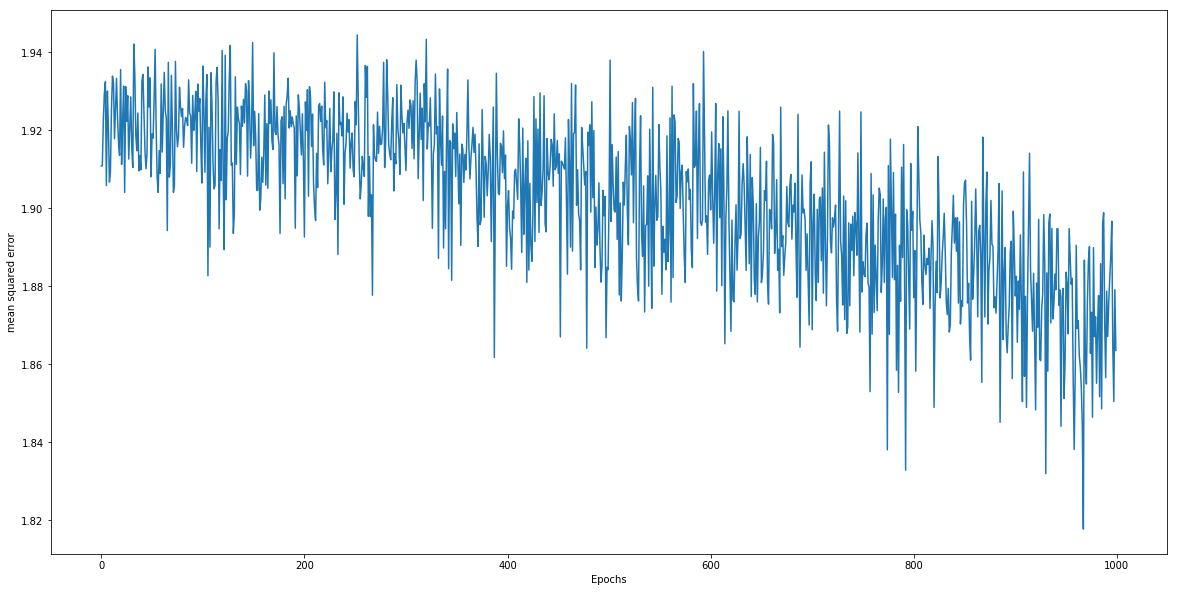

In [33]:
import matplotlib.pyplot as plt
# layer_number corresponds to the index of approximaion_list. 
# And reconstruct_error_arr is the np.ndarray of reconstruction error rates.
reconstruct_error_arr = dbm.get_reconstruct_error_arr(layer_number=0)
fig = plt.figure(figsize=(20, 10))
plt.plot(reconstruct_error_arr)
plt.xlabel("Epochs")
plt.ylabel("mean squared error")
plt.show();plt.close()

## Extract the result of dimention reduction

And the result of dimention reduction can be extracted by this property.

In [26]:
pre_trained_arr = dbm.feature_points_arr

## Extract weights obtained by pre-training.

If you want to get the pre-training weights, call get_weight_arr_list method.

In [27]:
weight_arr_list = dbm.get_weight_arr_list()

`weight_arr_list` is the list of weights of each links in DBM. `weight_arr_list[0]` is 2-d np.ndarray of weights between visible layer and first hidden layer.

## Extract biases obtained by pre-training.
Call get_visible_bias_arr_list method and get_hidden_bias_arr_list method in the same way.

In [28]:
visible_bias_arr_list = dbm.get_visible_bias_arr_list()
hidden_bias_arr_list = dbm.get_hidden_bias_arr_list()

`visible_bias_arr_list` and `hidden_bias_arr_list` are the list of biases of each links in DBM.

## Save pre-learned parameters.

Call `save_pre_learned_params` method.

In [29]:
dbm.save_pre_learned_params(dir_path="pre-learned", file_name="dbm_demo")

## Transfer learning in DBM.
`DBMMultiLayerBuilder` can be given `pre_learned_path_list`, which is a `list` of file paths stored by pre-training.

In [30]:
next_target_arr = np.random.normal(loc=0.0, scale=1.0, size=(1000, 1000))
next_target_arr = (next_target_arr - next_target_arr.mean()) / next_target_arr.std()

dbm_t = StackedAutoEncoder(
    DBMMultiLayerBuilder(
        pre_learned_path_list=[
            "pre-learned/dbm_demo_0.npz",
            "pre-learned/dbm_demo_1.npz"
        ]
    ),
    [next_target_arr.shape[1], 100, next_target_arr.shape[1]],
    activation_list,
    approximaion_list,
    # Setting learning rate.
    1e-05
)

# Execute learning.
dbm_t.learn(
    next_target_arr,
    training_count=1000, # If approximation is the Contrastive Divergence, this parameter is `k` in CD method.
    batch_size=100,  # Batch size in mini-batch training.
    r_batch_size=-1  # if `r_batch_size` > 0, the function of `dbm.learn` is a kind of reccursive learning.
)

## Extract reconstruction error rate.

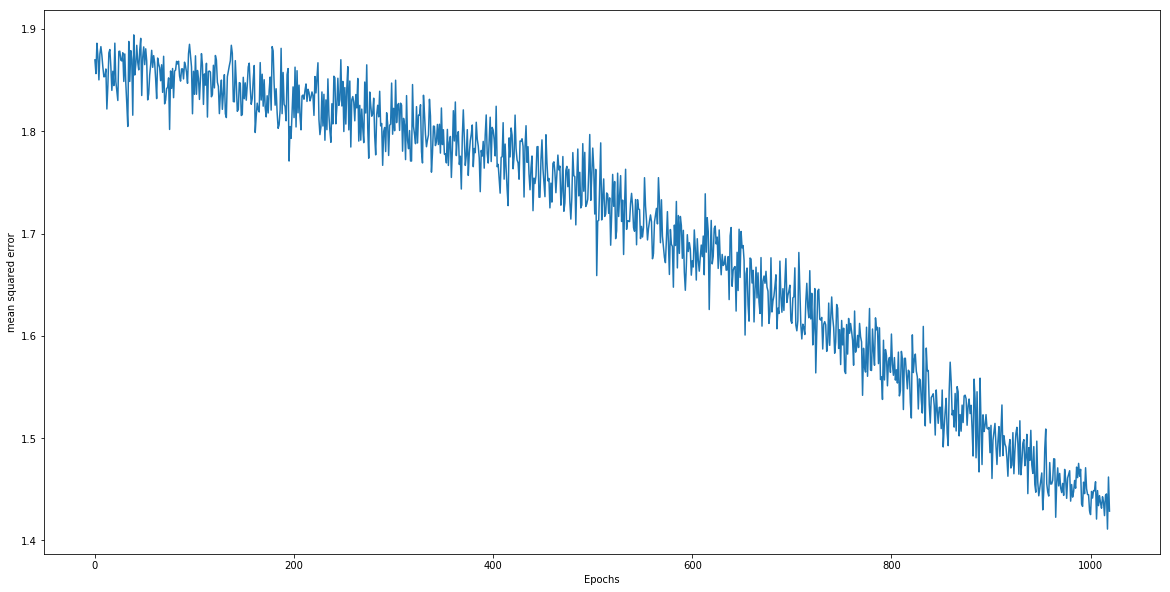

In [34]:
reconstruct_error_arr = dbm_t.get_reconstruct_error_arr(layer_number=0)
fig = plt.figure(figsize=(20, 10))
plt.plot(reconstruct_error_arr[1000:])
plt.xlabel("Epochs")
plt.ylabel("mean squared error")
plt.show();plt.close()

# References

- Ackley, D. H., Hinton, G. E., & Sejnowski, T. J. (1985). A learning algorithm for Boltzmann machines. Cognitive science, 9(1), 147-169.
- Hinton, G. E. (2002). Training products of experts by minimizing contrastive divergence. Neural computation, 14(8), 1771-1800.
- Le Roux, N., & Bengio, Y. (2008). Representational power of restricted Boltzmann machines and deep belief networks. Neural computation, 20(6), 1631-1649.
- Salakhutdinov, R., & Hinton, G. E. (2009). Deep boltzmann machines. InInternational conference on artificial intelligence and statistics (pp. 448-455).